In [1]:
#Importing libraries
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [2]:
%pwd

'E:\\GAN for Face expression Classification\\Research Kartik'

In [3]:
import os

In [4]:
os.chdir("../")

In [5]:
%pwd

'E:\\GAN for Face expression Classification'

In [6]:
import logging
from pathlib import Path
logging.basicConfig(
    # filename='extract_data.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [7]:
import os
import shutil
from pathlib import Path
from PIL import Image
import logging

class CopyAndAugmentBalancedDataset:
    def __init__(self, source_directory, copy_directory, target_size=(256, 256)):
        self.source_directory = Path(source_directory)
        self.copy_directory = Path(copy_directory)
        self.target_size = target_size
        self.class_indices = self._get_class_indices()
        # Calculate min_count after obtaining all class indices to ensure it is available when needed
        self.min_count = min(len(files) for files in self.class_indices.values())
        self._log_class_info()

    def _get_class_indices(self):
        """Scan the source directory and map each class to its images."""
        class_indices = {}
        for class_name in os.listdir(self.source_directory):
            class_path = self.source_directory / class_name
            if class_path.is_dir():
                class_indices[class_name] = [str(class_path / fname) for fname in os.listdir(class_path)]
        return class_indices

    def _log_class_info(self):
        """Log information about the classes and their image counts."""
        logging.info(f"Number of unique classes: {len(self.class_indices)}")
        for class_name, files in self.class_indices.items():
            logging.info(f"Count of images in {class_name}: {len(files)}")
        logging.info(f"Minimum frequency among classes: {self.min_count}")

    def _augment_and_copy_image(self, source_path, target_path):
        """Resize image and save to target path."""
        try:
            with Image.open(source_path) as img:
                img_resized = img.resize(self.target_size, Image.Resampling.LANCZOS)
                img_resized.save(target_path)
            logging.debug(f"Image {source_path} resized and copied to {target_path}")
        except Exception as e:
            logging.error(f"Error processing image {source_path}: {e}")

    def copy_and_augment_balanced_dataset(self):
        """Copy and augment a balanced dataset to the copy directory."""
        logging.info("Starting to copy and augment the dataset...")
        for class_name, files in self.class_indices.items():
            copy_path = self.copy_directory / class_name
            copy_path.mkdir(parents=True, exist_ok=True)
            # Ensure we only process up to min_count images per class
            selected_files = files[:self.min_count]
            for file_path in selected_files:
                target_file_path = copy_path / Path(file_path).name
                self._augment_and_copy_image(file_path, target_file_path)
        logging.info(f"Augmented balanced dataset copied to {self.copy_directory}")


In [8]:
# source_directory = Path(os.getcwd()) / "Dataset/images" / "train"
# copy_directory = Path(os.getcwd()) / "Dataset/images" / "Balanced_train"
# augmented_dataset_copier = CopyAndAugmentBalancedDataset(source_directory, copy_directory, target_size=(256, 256))
# augmented_dataset_copier.copy_and_augment_balanced_dataset()


In [9]:
import os
import shutil
from pathlib import Path
from PIL import Image
import logging

class CheckBalancedDataset:
    def __init__(self, source_directory, log_class_stats=False):
        self.source_directory = Path(source_directory)
        self.class_indices = self._get_class_indices()
        if log_class_stats:
            self._log_class_info()

    def _get_class_indices(self):
        """Scan the source directory and map each class to its images."""
        class_indices = {}
        for class_name in os.listdir(self.source_directory):
            class_path = self.source_directory / class_name
            if class_path.is_dir():
                class_indices[class_name] = len(os.listdir(class_path))
        return class_indices

    def _log_class_info(self):
        """Log information about the classes and their image counts."""
        logging.info(f"Number of unique classes: {len(self.class_indices)}")
        for class_name, count in self.class_indices.items():
            logging.info(f"Count of images in {class_name}: {count}")

source_directory = Path(os.getcwd()) / "Dataset/images" / "Balanced_train"

log_class_stats = "yes"

balanced_dataset_checker = CheckBalancedDataset(source_directory, log_class_stats=log_class_stats)


2024-04-14 18:43:31 - INFO - Number of unique classes: 7
2024-04-14 18:43:31 - INFO - Count of images in angry: 436
2024-04-14 18:43:31 - INFO - Count of images in disgust: 436
2024-04-14 18:43:31 - INFO - Count of images in fear: 436
2024-04-14 18:43:31 - INFO - Count of images in happy: 436
2024-04-14 18:43:31 - INFO - Count of images in neutral: 436
2024-04-14 18:43:31 - INFO - Count of images in sad: 436
2024-04-14 18:43:31 - INFO - Count of images in surprise: 436


In [10]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! You can use GPU for accelerated computations.")
else:
    print("CUDA is not available. You can use CPU for computations.")


CUDA is not available. You can use CPU for computations.


# Loading Angry only dataset

In [59]:
# #Parameters

# # Root directory for dataset
# dataroot = Path(os.getcwd()) / "Dataset/images" / "Balanced_train" / "angry"

# # Number of workers for dataloader
# workers = 0

# # Batch size during training
# batch_size = 128

# # Spatial size of training images. All images will be resized to this size using a transformer.
# image_size = 64

# # Number of channels in the training images. For color images this is 3
# nc = 3

# # Size of z latent vector (i.e. size of generator input)
# nz = 100

# # Size of feature maps in generator
# ngf = 64

# # Size of feature maps in discriminator
# ndf = 64

# # Number of training epochs
# num_epochs = 20

# # Learning rate for optimizers
# lr = 0.0002

# # Beta1 hyperparameter for Adam optimizers
# beta1 = 0.5

# # Number of GPUs available. Use 0 for CPU mode.
# ngpu = 1

In [60]:
# import torch
# from torchvision import transforms
# from torch.utils.data import Dataset
# from PIL import Image
# import os
# import numpy as np

# # Define transformations to be applied to the images
# transform = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.CenterCrop(image_size),
#     transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,)),  # Adjust normalization parameters for single-channel images
# ])

# # Define the custom dataset class
# class SingleClassDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_paths = [os.path.join(root_dir, filename) for filename in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, filename))]

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_name = self.image_paths[idx]
#         image = Image.open(img_name)
#         if self.transform:
#             image = self.transform(image)
        
#         # Generate a random label (0 or 1) for each image
#         label = np.random.randint(2)  # Randomly choose 0 or 1
        
#         return image, label

# # Create an instance of the custom dataset
# single_class_dataset = SingleClassDataset(root_dir=dataroot, transform=transform)

# # Create a DataLoader to iterate over the dataset
# dataloader = torch.utils.data.DataLoader(single_class_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)


# Loading complete face dataset

In [94]:
#Parameters

# Root directory for dataset
dataroot = Path(os.getcwd()) / "Dataset/images" / "Balanced_train"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [95]:
#Preparing the dataset and applying transformations to the images in the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

#Actually loading the data
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [96]:
# Deciding which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cpu')

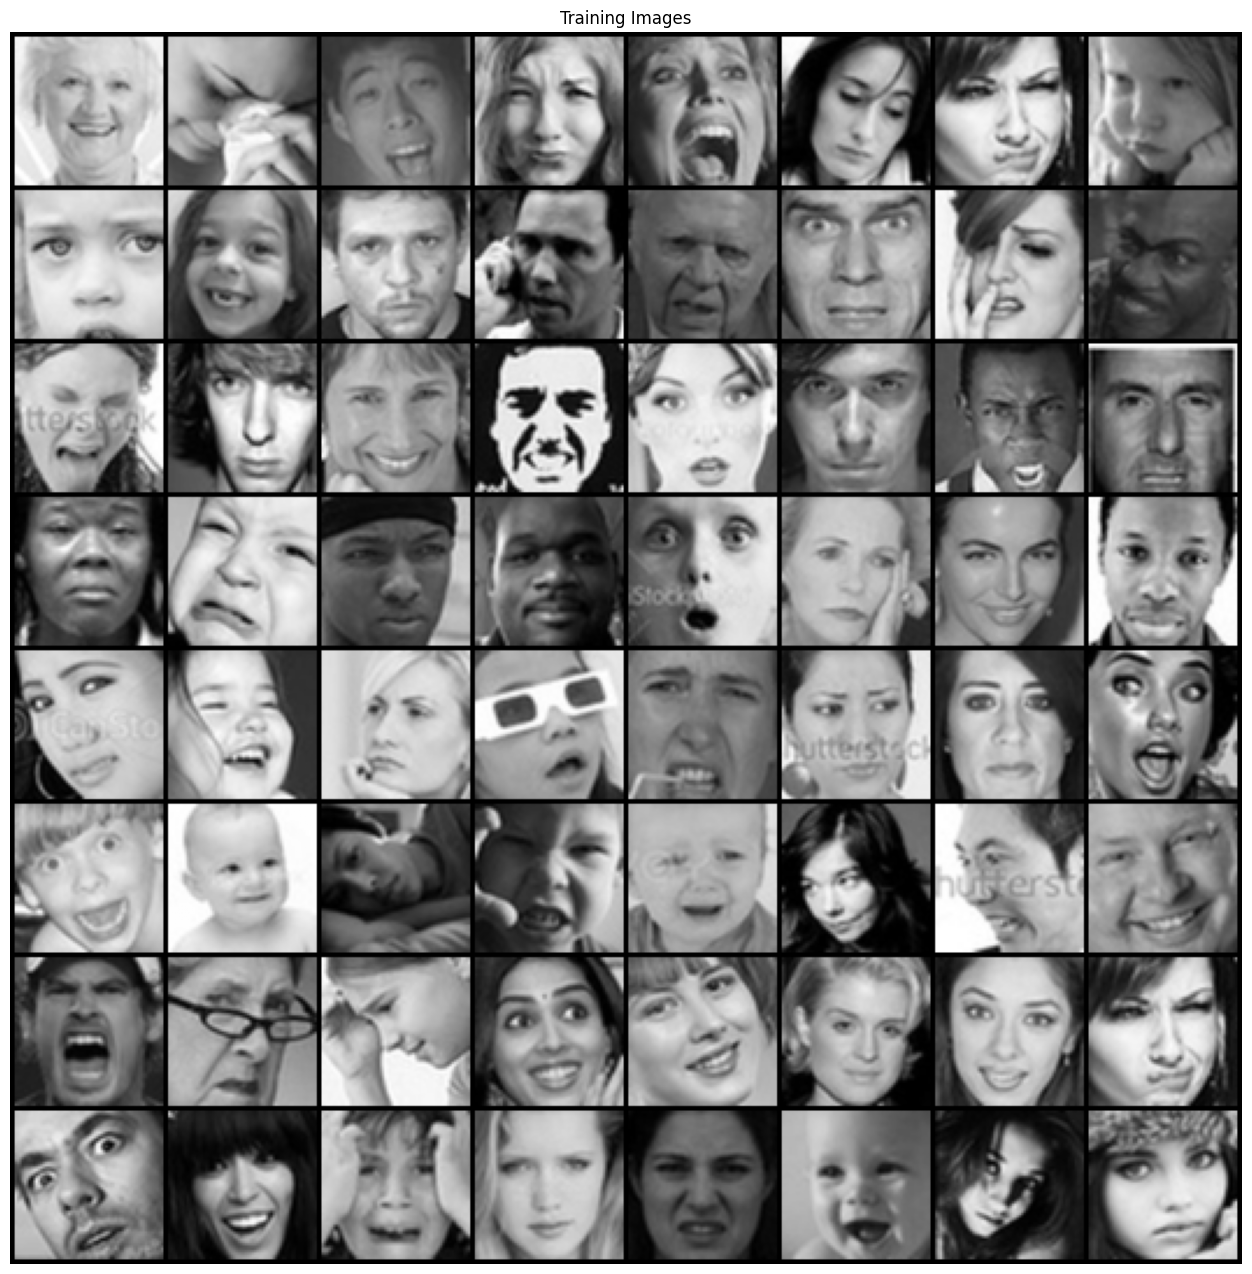

In [97]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()

In [98]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) #mean, stddev as given in the paper
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [99]:
#Generator Code
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [100]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [101]:
#Creating the discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [102]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [103]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Angry Save Directory

In [104]:
import os

# Define base save directory
save_dir = Path(os.getcwd()) / "Model/Class_based_gan/angry"
# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)


In [105]:
# Load the generator model state
netG.load_state_dict(torch.load(os.path.join(save_dir, 'netG_epoch_19.pth'), map_location=torch.device('cpu')))

# Load the discriminator model state
netD.load_state_dict(torch.load(os.path.join(save_dir, 'netD_epoch_19.pth'), map_location=torch.device('cpu')))

<All keys matched successfully>

# Loading the basic Face gan

In [106]:
import os

# Define base save directory
load_dir = Path(os.getcwd()) / "Model/GAN"
# Ensure the directory exists
os.makedirs(load_dir, exist_ok=True)


In [107]:
# # Load the generator model state
# netG.load_state_dict(torch.load(os.path.join(load_dir, 'netG_epoch_114.pth'), map_location=torch.device('cpu')))

# # Load the discriminator model state
# netD.load_state_dict(torch.load(os.path.join(load_dir, 'netD_epoch_114.pth'), map_location=torch.device('cpu')))

# Training angry gan

In [108]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    torch.save(netG.state_dict(), os.path.join(save_dir, f'netG_epoch_{epoch}.pth'))
    torch.save(netD.state_dict(), os.path.join(save_dir,  f'netD_epoch_{epoch}.pth'))

Starting Training Loop...
[0/20][0/24]	Loss_D: 0.0922	Loss_G: 2.1833	D(x): 0.9246	D(G(z)): 0.0038 / 0.2501
[1/20][0/24]	Loss_D: 0.0113	Loss_G: 6.4067	D(x): 0.9982	D(G(z)): 0.0093 / 0.0042
[2/20][0/24]	Loss_D: 0.1874	Loss_G: 5.0692	D(x): 0.9481	D(G(z)): 0.0877 / 0.0205
[3/20][0/24]	Loss_D: 0.0418	Loss_G: 5.5636	D(x): 0.9856	D(G(z)): 0.0256 / 0.0112
[4/20][0/24]	Loss_D: 0.0272	Loss_G: 5.8728	D(x): 0.9946	D(G(z)): 0.0208 / 0.0071
[5/20][0/24]	Loss_D: 0.0278	Loss_G: 5.8210	D(x): 0.9881	D(G(z)): 0.0150 / 0.0085
[6/20][0/24]	Loss_D: 0.0231	Loss_G: 6.1183	D(x): 0.9848	D(G(z)): 0.0076 / 0.0065
[7/20][0/24]	Loss_D: 0.0058	Loss_G: 7.3347	D(x): 0.9974	D(G(z)): 0.0031 / 0.0023
[8/20][0/24]	Loss_D: 0.0168	Loss_G: 6.5998	D(x): 0.9906	D(G(z)): 0.0071 / 0.0048
[9/20][0/24]	Loss_D: 0.0126	Loss_G: 6.3617	D(x): 0.9975	D(G(z)): 0.0100 / 0.0040
[10/20][0/24]	Loss_D: 0.0088	Loss_G: 6.7462	D(x): 0.9957	D(G(z)): 0.0044 / 0.0034
[11/20][0/24]	Loss_D: 0.0206	Loss_G: 6.0678	D(x): 0.9900	D(G(z)): 0.0104 / 0.0053


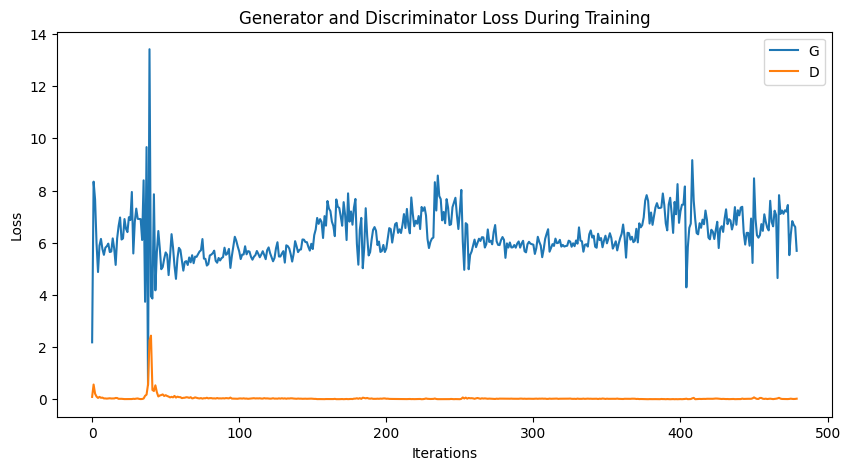

Loss plot saved at: E:\GAN for Face expression Classification\Model\Class_based_gan\angry\loss_plot.png


In [109]:
# Define the plot
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
# Display the plot
plt.show()
# Save the plot
save_path = save_dir / "loss_plot.png"
plt.savefig(save_path)
plt.close()

print(f"Loss plot saved at: {save_path}")



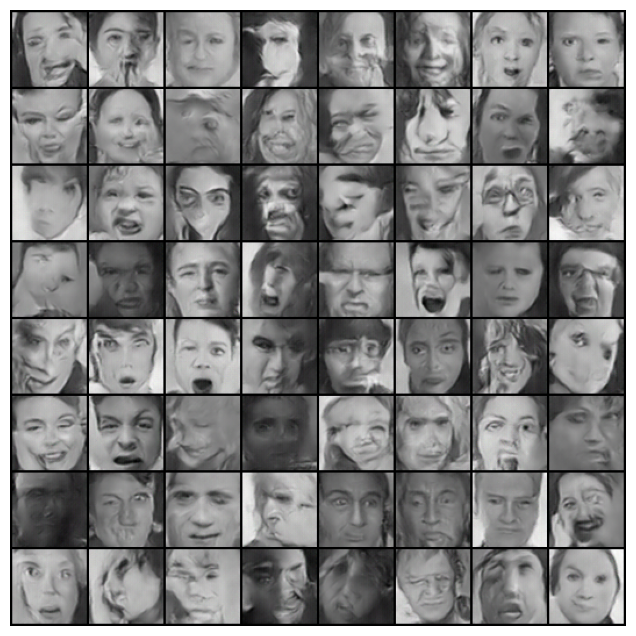

In [110]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

# Loading Model from Angry Gan

In [111]:
# Load the generator model state
netG.load_state_dict(torch.load(os.path.join(save_dir, 'netG_epoch_19.pth'), map_location=torch.device('cpu')))

# Load the discriminator model state
netD.load_state_dict(torch.load(os.path.join(save_dir, 'netD_epoch_19.pth'), map_location=torch.device('cpu')))

<All keys matched successfully>

In [112]:
img_list = []
with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

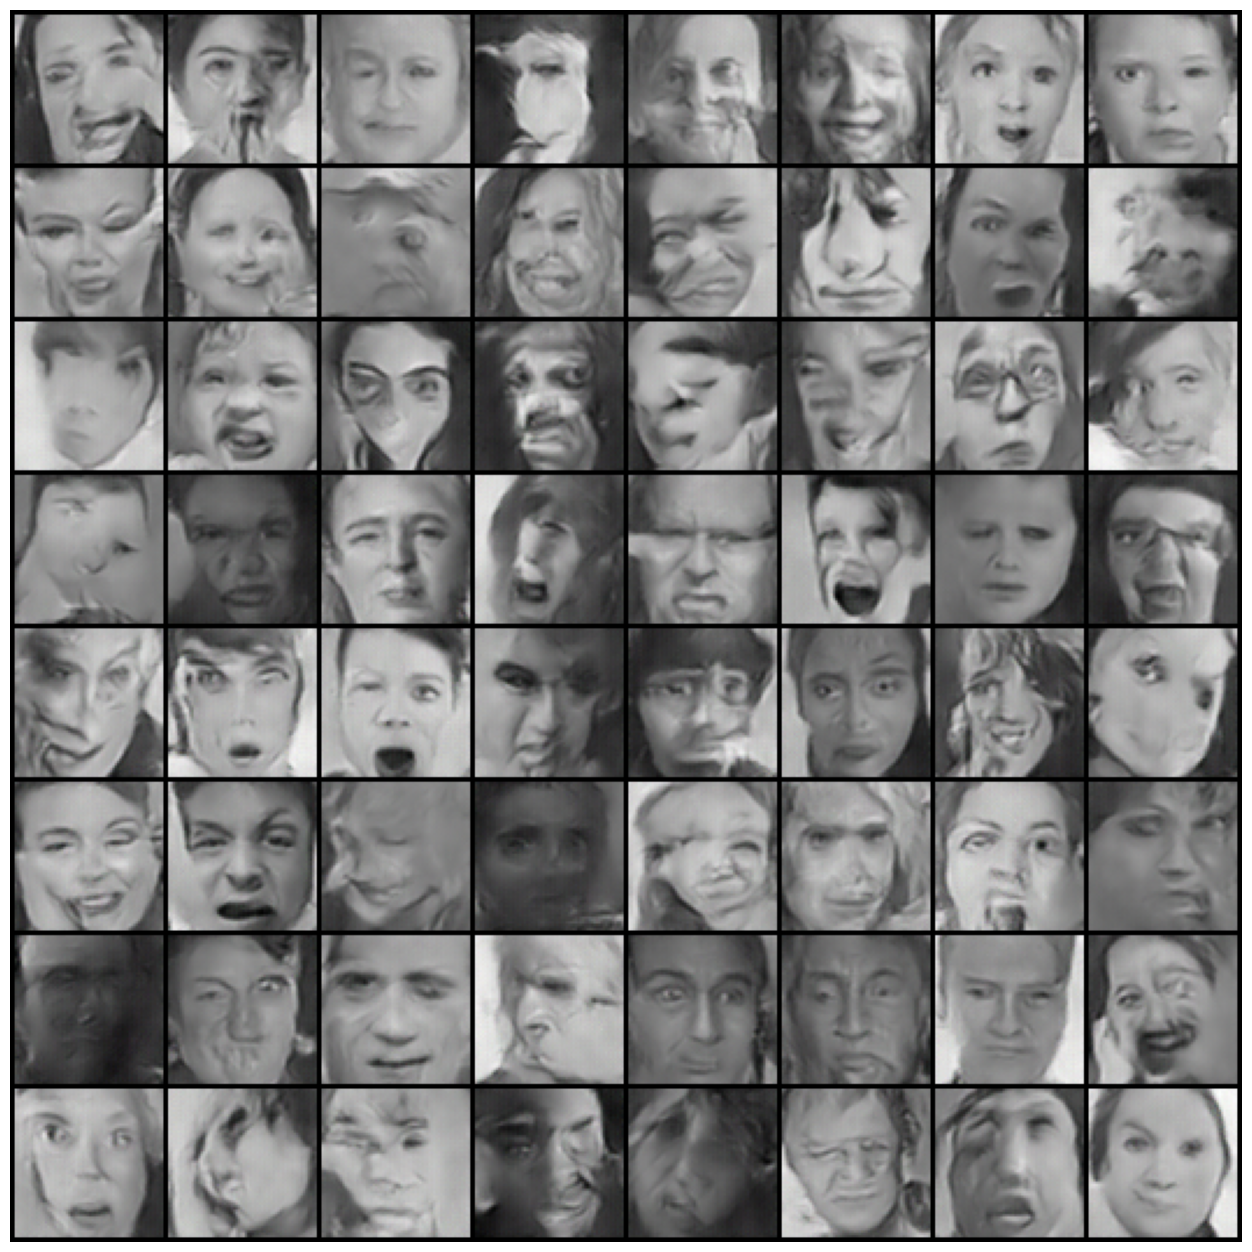

In [113]:
fig = plt.figure(figsize=(16,16))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]